In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from PIL import Image

In [ ]:
files = tf.data.Dataset.list_files("gs://rl_unplugged/atari_episodes_ordered/*/run_*", shuffle=True)
episodes_dataset = files.interleave(
    lambda f: tf.data.TFRecordDataset(f, compression_type="GZIP"),
    cycle_length=tf.data.AUTOTUNE,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=False
)

In [ ]:
raw_example = next(iter(episodes_dataset))

example = tf.train.Example()
example.ParseFromString(raw_example.numpy())

print("Features in the TFRecord example:")
for key in example.features.feature.keys():
    feature = example.features.feature[key]
    if feature.bytes_list.value:
        dtype = "bytes"
    elif feature.int64_list.value:
        dtype = "int64"
    elif feature.float_list.value:
        dtype = "float"
    else:
        dtype = "unknown"
    print(f"{key}: {dtype}")

Features in the TFRecord example:
clipped_rewards: float
unclipped_rewards: float
discounts: float
clipped_episode_return: float
episode_return: float
observations: bytes
actions: int64
checkpoint_idx: int64
episode_idx: int64


[0] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


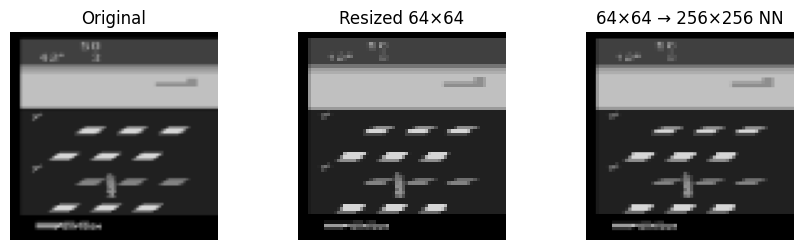

[1] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


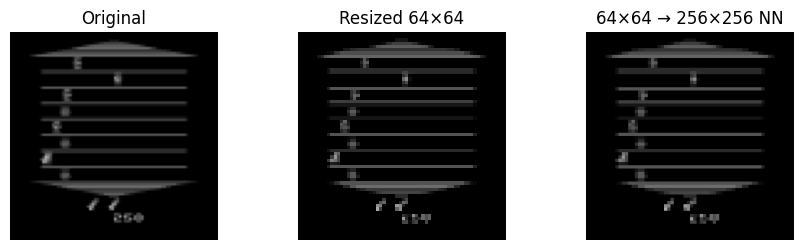

[2] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


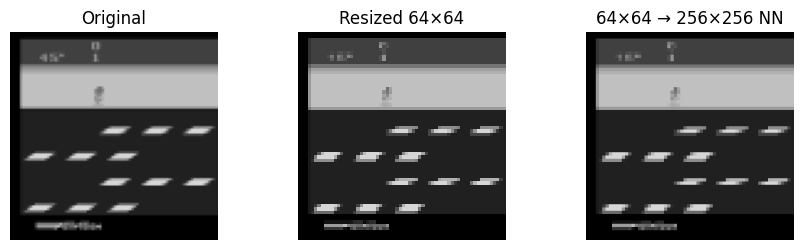

[3] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


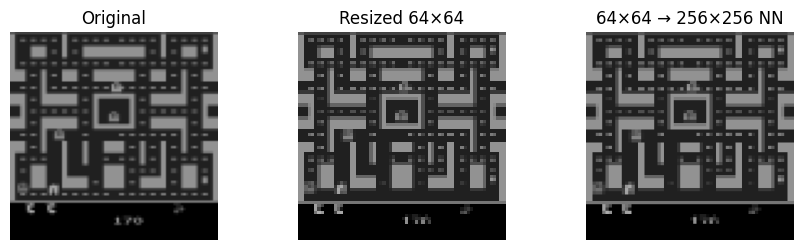

[4] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


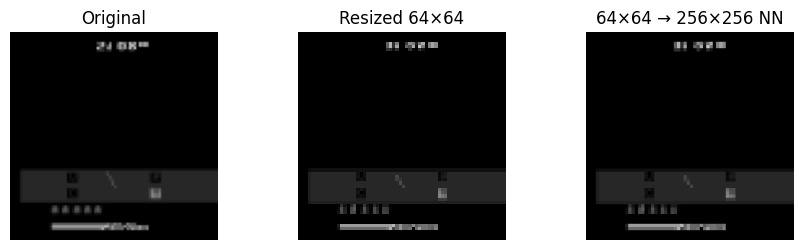

[5] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


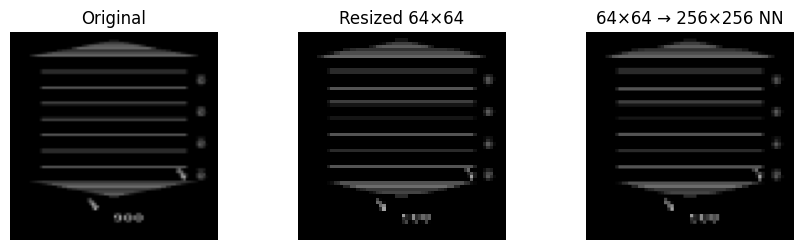

[6] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


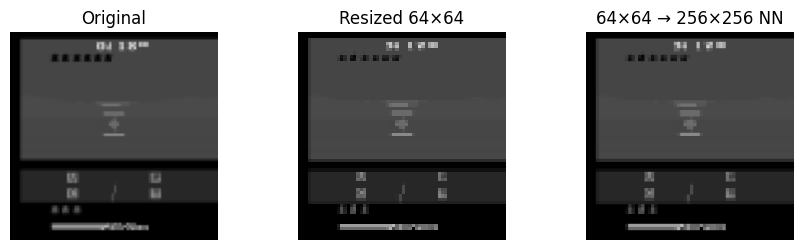

[7] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


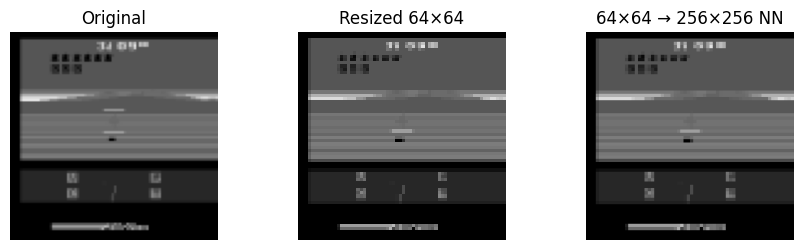

[8] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


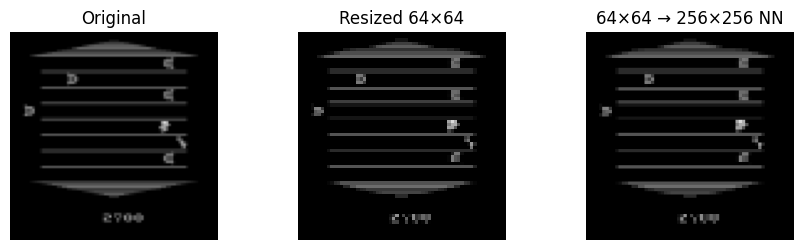

[9] ORIG (84, 84, 3)  |  64×64 (64, 64, 3)  |  256-from-64 (256, 256, 3)


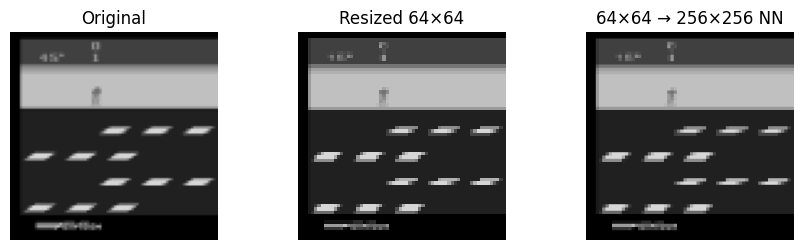

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# ---- TFRecord schema ----
feature_description = {
    "observations": tf.io.VarLenFeature(tf.string),
    "actions": tf.io.VarLenFeature(tf.int64),
    "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

# ---- Parse one random frame; return (original_uint8, resized_64_uint8, up_256_from_64_uint8) ----
def parse_random_frame_triplet(serialized,
                               size=64,
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR):
    parsed = tf.io.parse_single_example(serialized, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])  # (T,)
    T = tf.shape(obs)[0]
    i = tf.random.uniform([], 0, T, dtype=tf.int32)

    # Original frame (uint8)
    img = tf.io.decode_image(obs[i], channels=3)      # [Ho,Wo,3] uint8
    img.set_shape([None, None, 3])

    # Float for resizing
    img_f = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]

    # 64×64 with NEAREST (keeps pixel art crisp)
    img64_f = tf.image.resize(img_f, [size, size], method=method)
    img64   = tf.image.convert_image_dtype(img64_f, tf.uint8, saturate=True)
    img64.set_shape([size, size, 3])

    # 256×256 by 4× upsampling the 64×64 (pure pixel replication)
    img256_from64_f = tf.image.resize(img64_f, [size*4, size*4],
                                      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img256_from64   = tf.image.convert_image_dtype(img256_from64_f, tf.uint8, saturate=True)
    img256_from64.set_shape([size*4, size*4, 3])

    return img, img64, img256_from64

# ---- Build dataset over all games ----
files = tf.data.Dataset.list_files("gs://rl_unplugged/atari_episodes_ordered/*/run_*", shuffle=True)
episodes_dataset = files.interleave(
    lambda f: tf.data.TFRecordDataset(f, compression_type="GZIP"),
    cycle_length=tf.data.AUTOTUNE,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=False
).shuffle(1000)

triplets_ds = episodes_dataset.map(
    lambda x: parse_random_frame_triplet(
        x, size=64, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

# ---- Visualize: Original | 64×64 | (64×64)→256×256 ----
for i, (orig, img64, img256_from64) in enumerate(triplets_ds.take(10)):
    o  = orig.numpy()            # [Ho,Wo,3] uint8
    r  = img64.numpy()           # [64,64,3] uint8
    r4 = img256_from64.numpy()   # [256,256,3] uint8

    print(
        f"[{i}] ORIG {o.shape}  |  64×64 {r.shape}  |  256-from-64 {r4.shape}"
    )

    fig, axes = plt.subplots(1, 3, figsize=(8.8, 2.6))
    axes[0].imshow(o);  axes[0].set_title("Original");           axes[0].axis('off')
    axes[1].imshow(r);  axes[1].set_title("Resized 64×64");      axes[1].axis('off')
    axes[2].imshow(r4); axes[2].set_title("64×64 → 256×256 NN"); axes[2].axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
!git clone https://github.com/Coluding/world-models.git

Cloning into 'world-models'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 65 (delta 13), reused 59 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 153.67 KiB | 2.96 MiB/s, done.
Resolving deltas: 100% (13/13), done.


## Resizing to 256 x 256

In [ ]:
# --- TFRecord schema (unchanged) ---
feature_description = {
    "observations": tf.io.VarLenFeature(tf.string),
    "actions": tf.io.VarLenFeature(tf.int64),
    "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def _decode_uint8(x):
    img = tf.io.decode_image(x, channels=3, expand_animations=False)  # [H,W,3] uint8
    img.set_shape([None, None, 3])
    return img

def _to_64_then_256(img_uint8):
    # 64x64 (nearest) -> 256x256 (nearest); keeps Atari pixel art crisp
    x = tf.image.convert_image_dtype(img_uint8, tf.float32)                 # [0,1]
    x64  = tf.image.resize(x, [64, 64],  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    x256 = tf.image.resize(x64, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return x256  # float32 [0,1], shape [256,256,3]

def parse_sequence_64to256(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    acts = tf.sparse.to_dense(parsed["actions"])
    rews = tf.sparse.to_dense(parsed["clipped_rewards"])

    imgs_uint8 = tf.map_fn(_decode_uint8, obs, fn_output_signature=tf.uint8)        # (T, H, W, 3)
    imgs_256   = tf.map_fn(_to_64_then_256, imgs_uint8, fn_output_signature=tf.float32)  # (T,256,256,3)
    return imgs_256, tf.cast(acts, tf.int64), tf.cast(rews, tf.float32)

episodes_dataset = tf.data.TFRecordDataset(
    tf.io.gfile.glob("gs://rl_unplugged/atari_episodes_ordered/*/run_*"),
    compression_type="GZIP",
    num_parallel_reads=tf.data.AUTOTUNE
)

SEQ_LEN = 50
BATCH_TF = 8

dataset = (episodes_dataset
           .map(parse_sequence_64to256, num_parallel_calls=tf.data.AUTOTUNE)
           .filter(lambda im, a, r: tf.shape(im)[0] >= SEQ_LEN)
           .map(lambda im, a, r: (im[:SEQ_LEN], a[:SEQ_LEN], r[:SEQ_LEN]))
           .batch(BATCH_TF, drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE))


In [ ]:
import sys
sys.path.append('/content/world-models')

import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
for imgs, actions, rewards in dataset.take(2):
  print("imgs:", imgs.shape)
  print("actions:", actions.shape)
  print("rewards:", rewards.shape)

imgs: (8, 50, 256, 256, 3)
actions: (8, 50)
rewards: (8, 50)
imgs: (8, 50, 256, 256, 3)
actions: (8, 50)
rewards: (8, 50)


In [ ]:
def parse_sequence_for_inspection(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
    print("Original image shape (before resizing):", imgs.shape)
    return imgs

example = next(iter(episodes_dataset.take(1)))
imgs = parse_sequence_for_inspection(example)

Original image shape (before resizing): (567, 84, 84, 3)


In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

class AtariSequenceDataset(Dataset):
    def __init__(self, tf_dataset, num_tf_batches: int):
        self.frames, self.actions, self.rewards = [], [], []
        cnt = 0
        for imgs_tf, acts_tf, rews_tf in tf_dataset:
            B = imgs_tf.shape[0]
            imgs = imgs_tf.numpy().astype(np.float32)  # (B,T,256,256,3) already [0,1]
            acts = acts_tf.numpy()
            rews = rews_tf.numpy()
            for b in range(B):
                self.frames.append(imgs[b])   # (T,256,256,3)
                self.actions.append(acts[b])
                self.rewards.append(rews[b])
            cnt += 1
            if cnt >= num_tf_batches:
                break
    def __len__(self): return len(self.frames)
    def __getitem__(self, idx):
        imgs = torch.from_numpy(self.frames[idx])       # (T,256,256,3) float32 [0,1]
        acts = torch.from_numpy(self.actions[idx]).long()
        rews = torch.from_numpy(self.rewards[idx]).float()
        return imgs, acts, rews



In [ ]:
# Tune as needed
BATCH_TORCH = 16       # number of sequences per batch
NUM_WORKERS = 4       # >0 for speed; set 0 on Windows/Colab CPU-only
DROP_LAST   = True    # keeps shapes stable

num_batches = 100
atari_dataset = AtariSequenceDataset(dataset, num_batches)

pt_loader = DataLoader(
    atari_dataset,
    batch_size=BATCH_TORCH,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=DROP_LAST,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
)
print(f"Loaded {len(atari_dataset)} sequences. Batch size = {BATCH_TORCH}")

Loaded 800 sequences. Batch size = 16


# Training JEPA Decoder

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- robust GN group picker ---
def _pick_gn_groups(ch: int, max_groups: int = 32) -> int:
    """Return the largest divisor of ch that is <= max_groups (at least 1)."""
    for g in range(min(max_groups, ch), 0, -1):
        if ch % g == 0:
            return g
    return 1  # fallback

class TokenNorm(nn.Module):
    def __init__(self, d, max_groups=32, eps=1e-6):
        super().__init__()
        self.gn = nn.GroupNorm(_pick_gn_groups(d, max_groups), d, eps=eps, affine=True)
    def forward(self, x):  # (N,D,Ht,Wt)
        return self.gn(x)

def _build_2d_sincos_pos_embed(h, w, dim):
    # Fixed sin/cos (fast, no parameters)
    yy, xx = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    pos = torch.stack([yy, xx], dim=-1).float()  # (H,W,2)
    omega = torch.arange(dim // 4).float() / max(1, (dim // 4))
    omega = 1.0 / (10000 ** omega)               # (dim/4,)
    out = []
    for i in range(2):  # y then x
        z = pos[..., i].reshape(-1, 1) * omega.reshape(1, -1)
        out += [torch.sin(z), torch.cos(z)]      # each (H*W, dim/4)
    pe = torch.cat(out, dim=-1)                  # (H*W, dim) or (H*W, dim-≤3)
    if pe.shape[1] < dim:                        # pad if not multiple of 4
        pe = F.pad(pe, (0, dim - pe.shape[1]))
    return pe  # (H*W, dim)

class VJEPADecoder(nn.Module):
    """
    ViT-style frame decoder (deterministic):
      tokens (N, D_in, Ht, Wt) -> image (N, C_out, 256, 256)

    • proj: D_in -> embed_dim
    • + 2D positional embedding (sincos fixed, or learned)
    • TransformerEncoder (depth × heads)
    • per-token Linear -> (p_h*p_w*C_out), then fold to 256×256
    """
    def __init__(self, d_in: int, h_tokens: int, w_tokens: int,
                 out_ch: int = 1, embed_dim: int = 512, depth: int = 12,
                 nheads: int = 8, mlp_ratio: float = 4.0, dropout: float = 0.0,
                 use_token_norm: bool = True, use_learned_pos: bool = False,
                 gn_groups: int = 32):
        super().__init__()
        assert h_tokens == w_tokens, "Expect square token grid."
        self.Ht, self.Wt = h_tokens, w_tokens
        self.out_ch = out_ch

        # Each token covers a 256/Ht by 256/Wt patch
        assert 256 % self.Ht == 0 and 256 % self.Wt == 0, "256 must be divisible by token grid."
        self.p_h = 256 // self.Ht
        self.p_w = 256 // self.Wt
        self.patch_vec = self.p_h * self.p_w * out_ch  # per-token output length

        self.tok_norm = TokenNorm(d_in, max_groups=gn_groups) if use_token_norm else nn.Identity()
        self.proj_in  = nn.Linear(d_in, embed_dim)

        # Positional embedding
        if use_learned_pos:
            self.pos = nn.Parameter(torch.zeros(1, self.Ht * self.Wt, embed_dim))
            nn.init.trunc_normal_(self.pos, std=0.02)
            self.register_buffer("pos_fixed", None, persistent=False)
        else:
            self.pos = None
            pe = _build_2d_sincos_pos_embed(self.Ht, self.Wt, embed_dim)  # (L, C)
            self.register_buffer("pos_fixed", pe.unsqueeze(0), persistent=False)  # (1, L, C)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nheads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.blocks = nn.TransformerEncoder(enc_layer, num_layers=depth)
        self.proj_patch = nn.Linear(embed_dim, self.patch_vec)
        self.out_norm = nn.Identity()  # keep outputs linear; clamp in training loop

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        tokens: (N, D_in, Ht, Wt) in fp32/fp16/bf16
        returns: (N, out_ch, 256, 256), same dtype as tokens' autocast stream
        """
        N, D, Ht, Wt = tokens.shape
        assert Ht == self.Ht and Wt == self.Wt, "Unexpected token grid."

        x = self.tok_norm(tokens).flatten(2).transpose(1, 2)  # (N, L=Ht*Wt, D_in)
        x = self.proj_in(x)                                   # (N, L, C)

        if self.pos is not None:
            pos = self.pos[:, :x.size(1)]
        else:
            # ensure dtype/device match AMP stream
            pos = self.pos_fixed[:, :x.size(1)].to(dtype=x.dtype, device=x.device)
        x = x + pos

        x = self.blocks(x)                                    # (N, L, C)
        x = self.proj_patch(x)                                # (N, L, p_h*p_w*out_ch)

        # fold to image
        x = x.view(N, Ht, Wt, self.out_ch, self.p_h, self.p_w).permute(0, 3, 1, 4, 2, 5)
        x = x.reshape(N, self.out_ch, Ht * self.p_h, Wt * self.p_w)  # (N, C, 256, 256)
        return self.out_norm(x)

def count_params(model: nn.Module):
    total = sum(p.numel() for p in model.parameters())
    train = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, train


In [ ]:
# ---------------------------------------------------------------
# Config
# ---------------------------------------------------------------
import os, math, numpy as np, tensorflow as tf
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

VJEPA_BACKEND = os.environ.get("VJEPA_BACKEND", "hub")   # "hub" or "hf"
USE_AC        = bool(int(os.environ.get("VJEPA_USE_AC", "0")))  # 1=use AC variant via hub
HF_REPO       = os.environ.get("VJEPA_HF_REPO", "facebook/vjepa2-vitl-fpc64-256")

# Data cfg
SEQ_LEN   = 50
BATCH_TF  = 8
BATCH_TORCH = 8
NUM_TF_BATCHES_TO_LOAD = int(os.environ.get("NUM_TF_BATCHES", "100"))

# Training cfg
K_FRAMES  = 12             # supervised frames per sequence (<= SEQ_LEN)
T_IN      = 4              # temporal context for V-JEPA clips
EPOCHS    = 300
LR        = 3e-4
ENCODER_MICROBATCH = 8     # sequences per encoder call (B*K dimension)
USE_BF16  = torch.cuda.is_bf16_supported()
USE_GRAYSCALE = True       # decoder outputs 1 channel if True

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# ---------------------------------------------------------------
# TFRecords -> tf.data (64 -> 256 via NEAREST)
# ---------------------------------------------------------------
feature_description = {
    "observations":   tf.io.VarLenFeature(tf.string),
    "actions":        tf.io.VarLenFeature(tf.int64),
    "clipped_rewards":tf.io.VarLenFeature(tf.float32),
}

def _decode_uint8(x):
    img = tf.io.decode_image(x, channels=3, expand_animations=False)  # [H,W,3] uint8
    img.set_shape([None, None, 3])
    return img

def _to_64_then_256(img_uint8):
    # 64x64 (nearest) -> 256x256 (nearest); keeps Atari pixel art crisp
    x    = tf.image.convert_image_dtype(img_uint8, tf.float32)  # [0,1]
    x64  = tf.image.resize(x,    [64, 64],   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    x256 = tf.image.resize(x64,  [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return x256  # float32 [0,1]

def parse_sequence_64to256(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    acts = tf.sparse.to_dense(parsed["actions"])
    rews = tf.sparse.to_dense(parsed["clipped_rewards"])

    imgs_uint8 = tf.map_fn(_decode_uint8,   obs,  fn_output_signature=tf.uint8)    # (T,H,W,3)
    imgs_256   = tf.map_fn(_to_64_then_256, imgs_uint8, fn_output_signature=tf.float32)  # (T,256,256,3)
    return imgs_256, tf.cast(acts, tf.int64), tf.cast(rews, tf.float32)

# All games (or narrow the glob if you want)
episodes_dataset = tf.data.TFRecordDataset(
    tf.io.gfile.glob("gs://rl_unplugged/atari_episodes_ordered/*/run_*"),
    compression_type="GZIP",
    num_parallel_reads=tf.data.AUTOTUNE
)

dataset = (episodes_dataset
           .map(parse_sequence_64to256, num_parallel_calls=tf.data.AUTOTUNE)
           .filter(lambda im, a, r: tf.shape(im)[0] >= SEQ_LEN)
           .map(lambda im, a, r: (im[:SEQ_LEN], a[:SEQ_LEN], r[:SEQ_LEN]))
           .batch(BATCH_TF, drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE))

# ---------------------------------------------------------------
# Load V-JEPA 2 (hub or HF), frozen
# ---------------------------------------------------------------
preprocessor = None
vjepa_model  = None
vjepa_ac_predictor = None

if VJEPA_BACKEND == "hub":
    preprocessor = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_preprocessor')
    if USE_AC:
        obj = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_ac_vit_giant')
        if isinstance(obj, tuple):
            vjepa_model, vjepa_ac_predictor = obj[0], obj[1]
        else:
            vjepa_model = obj
        print("Loaded V-JEPA 2-AC (ViT-g) from hub.")
    else:
        obj = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_vit_large')
        vjepa_model = obj[0] if isinstance(obj, tuple) else obj
        print("Loaded V-JEPA 2 (ViT-L) from hub.")
    vjepa_model.to(device).eval()
    for p in vjepa_model.parameters(): p.requires_grad_(False)

elif VJEPA_BACKEND == "hf":
    from transformers import AutoVideoProcessor, AutoModel
    vjepa_model = AutoModel.from_pretrained(HF_REPO).to(device).eval()
    preprocessor = AutoVideoProcessor.from_pretrained(HF_REPO)
    for p in vjepa_model.parameters(): p.requires_grad_(False)
    print(f"Loaded {HF_REPO} from Hugging Face.")
else:
    raise ValueError("VJEPA_BACKEND must be 'hub' or 'hf'.")

# ---------------------------------------------------------------
# Token helpers
# ---------------------------------------------------------------
def _infer_grid_hw():
    """Infer (Ht, Wt) token grid from the V-JEPA patch embed (expects 256×256 inputs)."""
    if hasattr(vjepa_model, "patch_embed"):
        pe = vjepa_model.patch_embed
        if getattr(pe, "grid_size", None) is not None:
            gs = pe.grid_size
            if isinstance(gs, (tuple, list)) and len(gs) == 2:
                return int(gs[0]), int(gs[1])
        patch = None
        if hasattr(pe, "patch_size"):
            ps = pe.patch_size
            patch = int(ps[0]) if isinstance(ps, (tuple, list)) else int(ps)
        target = 256
        if patch and target % patch == 0:
            return target // patch, target // patch
    return 16, 16  # safe fallback for ViT-L at 256

def _infer_temporal_T_and_tubelet():
    """Return (T_in, tubelet_t) reported by the encoder; you may override T_in."""
    T_in, tubelet_t = 16, 2
    pe = getattr(vjepa_model, "patch_embed", None)
    if pe is not None:
        if hasattr(pe, "tubelet_size"):
            ts = pe.tubelet_size  # e.g., (2, 16, 16)
            if isinstance(ts, (tuple, list)) and len(ts) >= 1:
                tubelet_t = int(ts[0])
        if hasattr(vjepa_model, "num_frames"):
            try: T_in = int(vjepa_model.num_frames)
            except Exception: pass
    return T_in, tubelet_t

@torch.no_grad()
def clips_to_center_tokens(frames_bkchw: torch.Tensor, override_T_in: int = 4) -> torch.Tensor:
    """
    frames_bkchw: (B, K, 3, 256, 256) float in [0,1]
    returns: (B, K, D, Ht, Wt)
    """
    B, K, C, H, W = frames_bkchw.shape
    assert C == 3 and H == 256 and W == 256, f"Expected (..,3,256,256), got {frames_bkchw.shape}"

    Ht_exp, Wt_exp = _infer_grid_hw()
    spatial_tokens = Ht_exp * Wt_exp

    T_model, _ = _infer_temporal_T_and_tubelet()
    T_in = min(int(override_T_in), int(K))
    dtype_amp = torch.bfloat16 if USE_BF16 else torch.float16

    if not hasattr(clips_to_center_tokens, "_printed"):
        print(f"[clips_to_center_tokens] Using T_in={T_in} (model reports {T_model}), K={K}, grid={Ht_exp}×{Wt_exp}")
        clips_to_center_tokens._printed = True

    # Build clamped temporal indices for all centers t
    idx_all = []
    for t in range(K):
        start = t - (T_in // 2)
        idx = torch.arange(start, start + T_in, device=frames_bkchw.device).clamp(0, K - 1)  # (T_in,)
        idx_all.append(idx)
    idx_all = torch.stack(idx_all, dim=0)  # (K, T_in)

    # Gather clips: (B, K, T_in, C, H, W) -> (B*K, C, T_in, 256, 256)
    clips = frames_bkchw.index_select(1, idx_all.view(-1)).view(B, K, T_in, C, H, W)
    clips_btchw = clips.view(B * K * T_in, C, H, W)  # (B*K*T_in, C, 256, 256)

    # Robust preprocessor loop (Hub preprocessor expects list items)
    proc_list = []
    for f in clips_btchw:                 # (C,H,W) float [0,1]
        out = preprocessor([f.cpu()])
        out = out[0] if isinstance(out, (list, tuple)) else out
        if out.dim() == 4:                # rare: (C,T,256,256)
            out = out[:, 0]
        proc_list.append(out)
    proc = torch.stack(proc_list, dim=0)  # (B*K*T_in, C, 256, 256)

    # (B*K*T_in, C, 256, 256) -> (B*K, C, T_in, 256, 256)
    proc = proc.view(B, K, T_in, C, 256, 256).reshape(B * K, T_in, C, 256, 256).permute(0, 2, 1, 3, 4).contiguous()
    del clips, clips_btchw, proc_list

    # Encode in micro-batches over the B*K dimension
    toks_chunks = []
    for s in range(0, B * K, ENCODER_MICROBATCH):
        e = min(B * K, s + ENCODER_MICROBATCH)
        mb_clip = proc[s:e].to(device, non_blocking=True)  # (b, C, T_in, 256, 256)
        with torch.autocast(device_type="cuda", dtype=dtype_amp):
            out = vjepa_model(mb_clip)

        # Normalize output to a token tensor
        if isinstance(out, (list, tuple)) and len(out) > 0:
            x = out[0]
        elif isinstance(out, dict):
            for k in ("x", "feats", "last_hidden_state", "tokens"):
                if k in out: x = out[k]; break
            else:
                x = next(iter(out.values()))
        else:
            x = out

        if x.dim() == 4:                      # (b, T', N, D)
            b, Tprime, N, D = x.shape
            x = x[:, Tprime // 2]             # -> (b, N, D)
        elif x.dim() == 3:                    # (b, N, D)
            b, N, D = x.shape
        else:
            raise RuntimeError(f"Unexpected V-JEPA output shape: {tuple(x.shape)}")

        # Map N tokens to (Ht,Wt,D)
        spatial = spatial_tokens
        if N % spatial == 0:
            G = N // spatial
            if G > 1:
                x = x.view(b, G, spatial, D)
                x = x[:, G // 2]              # center group if grouped
        else:
            take = min(N, spatial)
            x = x[:, :take, :]
            pad = spatial - take
            if pad > 0:
                x = torch.cat([x, x[:, -1:, :].expand(b, pad, D)], dim=1)

        toks = x.view(b, Ht_exp, Wt_exp, D).permute(0, 3, 1, 2).contiguous()  # (b, D, Ht, Wt)
        toks_chunks.append(toks)
        del mb_clip, out, x

    # Reassemble: (B*K, D, Ht, Wt) -> (B, K, D, Ht, Wt)
    toks_all  = torch.cat(toks_chunks, dim=0)
    tokens_bk = toks_all.view(B, K, toks_all.size(1), toks_all.size(2), toks_all.size(3))
    del proc, toks_chunks, toks_all
    # torch.cuda.empty_cache()  # optional

    return tokens_bk


Using device: cuda
Downloading: "https://github.com/facebookresearch/vjepa2/zipball/main" to /root/.cache/torch/hub/main.zip


Using cache found in /root/.cache/torch/hub/facebookresearch_vjepa2_main
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://dl.fbaipublicfiles.com/vjepa2/vitl.pt" to /root/.cache/torch/hub/checkpoints/vitl.pt


100%|██████████| 4.78G/4.78G [00:14<00:00, 362MB/s]


Loaded V-JEPA 2 (ViT-L) from hub.


## Instantiating Decoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


@torch.no_grad()
def probe_token_shape():
    dummy = torch.rand(2, K_FRAMES, 3, 256, 256, device=device)  # << was 84
    if hasattr(clips_to_center_tokens, "_printed"):
        del clips_to_center_tokens._printed
    toks_bk = clips_to_center_tokens(dummy, override_T_in=T_IN)
    b, k, d, ht, wt = toks_bk.shape
    print(f"[probe] token shape per frame: (D,Ht,Wt)=({d},{ht},{wt})  |  K={k}")
    return (d, ht, wt)



D_tok, Ht, Wt = probe_token_shape()
decoder = VJEPADecoder(
    d_in=D_tok, h_tokens=Ht, w_tokens=Wt,
    out_ch=1 if USE_GRAYSCALE else 3,
    embed_dim=1024, depth=16, nheads=8, mlp_ratio=4.0,
    dropout=0.0, use_token_norm=True, use_learned_pos=False
).to(device)

[clips_to_center_tokens] Using T_in=4 (model reports 64), K=12, grid=16×16


/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


[probe] token shape per frame: (D,Ht,Wt)=(1024,16,16)  |  K=12


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
from pathlib import Path
import time, torch

CKPT_DIR = Path("checkpoints/decoder")
CKPT_DIR.mkdir(parents=True, exist_ok=True)
run_tag = time.strftime("%Y%m%d-%H%M%S")
best_loss = float("inf")

def save_checkpoint(tag, epoch, update_step, is_best=False):
    ckpt = {
        "epoch": epoch,
        "update_step": update_step,
        "model_state": decoder.state_dict(),
        "optimizer_state": opt.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "scaler_state": scaler.state_dict(),
        "use_bf16": bool(USE_BF16),
        "amp_dtype": str(amp_dtype),
        # include any config you’ll want on resume:
        "config": {
            "K_FRAMES": int(K_FRAMES),
            "T_IN": int(T_IN),
            "USE_GRAYSCALE": bool(USE_GRAYSCALE),
            "arch": decoder.__class__.__name__,
        },
    }
    path = CKPT_DIR / f"{tag}.ckpt"
    torch.save(ckpt, path)
    if is_best:
        torch.save(ckpt, CKPT_DIR / "best.ckpt")

def save_weights_only():
    # weights-only (smallest thing you need for inference)
    torch.save({k: v.cpu() for k, v in decoder.state_dict().items()},
               CKPT_DIR / "decoder_weights.pt")


## Training Loop

In [ ]:
# ===== Full training loop =====
import math
import torch
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

# New Loss
def charbonnier(x, y, eps=1e-3):
    return torch.mean(torch.sqrt((x - y)**2 + eps**2))

torch.backends.cudnn.benchmark = True
# (Optional speedups on Ampere+)
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# --- Optimizer (paper-ish settings) ---
opt = torch.optim.AdamW(decoder.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.1)
clip_val = 1.0

# --- Grad accumulation to emulate ~1024 frames/update ---
B_guess = getattr(pt_loader, "batch_size", None)
if B_guess is None:
    # Fall back to your known config or a safe default
    B_guess = BATCH_TORCH if "BATCH_TORCH" in globals() else 1
frames_per_minibatch = max(1, K_FRAMES) * max(1, B_guess)
accum = max(1, 1024 // frames_per_minibatch)

# --- Schedule computed over *optimizer updates* ---
num_batches_per_epoch = len(pt_loader)
updates_per_epoch = math.ceil(num_batches_per_epoch / accum)
total_updates = EPOCHS * updates_per_epoch
warmup_updates = min(2000, max(100, int(0.05 * total_updates)))

scheduler = torch.optim.lr_scheduler.SequentialLR(
    opt,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.1, total_iters=warmup_updates),
        torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, total_updates - warmup_updates)),
    ],
    milestones=[warmup_updates],
)

# --- AMP / Scaler (disable scaler for bf16) ---
amp_dtype = torch.bfloat16 if USE_BF16 else torch.float16
scaler = torch.cuda.amp.GradScaler(enabled=not USE_BF16)

decoder.train()
global_step = 0       # minibatch counter
update_step = 0       # optimizer-step counter

for epoch in range(1, EPOCHS + 1):
    running_loss = 0.0

    for it, (imgs, _, _) in enumerate(pt_loader):
        # imgs: (B, T, 256, 256, 3) float32 in [0,1]  ->  (B, K, 3, 256, 256)
        imgs = imgs[:, :K_FRAMES].permute(0, 1, 4, 2, 3).contiguous().to(device)
        B, K = imgs.shape[:2]

        # Targets (grayscale if desired) at 256×256
        frames  = imgs.reshape(-1, 3, 256, 256)
        targets = (0.299*frames[:, 0:1] + 0.587*frames[:, 1:2] + 0.114*frames[:, 2:3]).contiguous() \
                  if USE_GRAYSCALE else frames

        # Encode tokens from 4-frame clips centered at each supervised frame
        with torch.no_grad():
            toks_bk = clips_to_center_tokens(imgs, override_T_in=T_IN)   # (B, K, D, Ht, Wt)

        tokens = toks_bk.reshape(-1, toks_bk.size(2), toks_bk.size(3), toks_bk.size(4))

        # Forward (no clamp; keep regression gradients intact)
        with torch.cuda.amp.autocast(dtype=amp_dtype):
            preds = decoder(tokens)  # (B*K, C_out, 256, 256)
            # If decoder outputs RGB but targets are 1ch, convert preds to luminance
            if preds.size(1) == 3 and targets.size(1) == 1:
                preds_gray = (0.299*preds[:, 0:1] + 0.587*preds[:, 1:2] + 0.114*preds[:, 2:3]).contiguous()
            else:
                preds_gray = preds

            # Compute loss in fp32 for stability
            # loss = F.mse_loss(preds_gray.float(), targets.float())
            loss = charbonnier(preds_gray, targets)            # even more edge-friendly

        # Backward w/ accumulation
        scaler.scale(loss / accum).backward()
        global_step += 1
        running_loss += loss.item()

        # Optimizer step every `accum` minibatches
        if global_step % accum == 0:
            # IMPORTANT: unscale before clipping
            scaler.unscale_(opt)
            clip_grad_norm_(decoder.parameters(), clip_val)

            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)

            scheduler.step()
            update_step += 1

        # One-time sanity print
        if epoch == 1 and it == 0:
            print("shapes — imgs:", tuple(imgs.shape),
                  "tokens:", tuple(tokens.shape),
                  "preds:", tuple(preds.shape),
                  "targets:", tuple(targets.shape))
            print(f"accum={accum}, updates_per_epoch={updates_per_epoch}, total_updates={total_updates}")

    # (Optional) flush partial accumulation at end of epoch so we don’t drop gradients
    if global_step % accum != 0:
        scaler.unscale_(opt)
        clip_grad_norm_(decoder.parameters(), clip_val)
        scaler.step(opt)
        scaler.update()
        opt.zero_grad(set_to_none=True)
        scheduler.step()
        update_step += 1

    avg_loss = running_loss / max(1, num_batches_per_epoch)
    tag = f"{run_tag}_epoch{epoch:03d}_loss{avg_loss:.4f}"
    save_checkpoint(tag, epoch, update_step, is_best=avg_loss < best_loss)
    if avg_loss < best_loss:
        best_loss = avg_loss

    save_weights_only()

    curr_lr = opt.param_groups[0]["lr"]
    print(f"Epoch {epoch}/{EPOCHS} | updates {update_step}/{total_updates} | lr {curr_lr:.2e} | mse {avg_loss:.4f}")


# Final full checkpoint + weights-only
save_checkpoint(f"{run_tag}_final", epoch, update_step, is_best=(avg_loss <= best_loss))
save_weights_only()

# Optional: TorchScript for portable inference (use eval + CPU)
decoder_cpu = decoder.eval().to("cpu")

# If your model is scriptable:
try:
    scripted = torch.jit.script(decoder_cpu)
    scripted.save(str(CKPT_DIR / "decoder_scripted.pt"))
except Exception:
    # Fallback to tracing if scripting fails; provide a dummy input with the right shape.
    # Replace D,Ht,Wt with your token dims (printed in your first-batch sanity log).
    D, Ht, Wt =  tokens.shape[1], tokens.shape[2], tokens.shape[3]  # capture during training
    example = torch.randn(1, D, Ht, Wt)
    traced = torch.jit.trace(decoder_cpu, example)
    traced.save(str(CKPT_DIR / "decoder_traced.pt"))

print("Done.")


/tmp/ipython-input-845698158.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=not USE_BF16)
/tmp/ipython-input-845698158.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=amp_dtype):


shapes — imgs: (16, 12, 3, 256, 256) tokens: (192, 1024, 16, 16) preds: (192, 1, 256, 256) targets: (192, 1, 256, 256)
accum=5, updates_per_epoch=10, total_updates=3000
Epoch 1/300 | updates 10/3000 | lr 8.00e-05 | mse 1.6826
Epoch 2/300 | updates 20/3000 | lr 1.10e-04 | mse 0.7192
Epoch 3/300 | updates 30/3000 | lr 1.40e-04 | mse 0.5579
Epoch 4/300 | updates 40/3000 | lr 1.70e-04 | mse 0.5673
Epoch 5/300 | updates 50/3000 | lr 2.00e-04 | mse 0.6797
Epoch 6/300 | updates 60/3000 | lr 2.30e-04 | mse 0.7940
Epoch 7/300 | updates 70/3000 | lr 2.60e-04 | mse 0.8686
Epoch 8/300 | updates 80/3000 | lr 2.90e-04 | mse 0.9074
Epoch 9/300 | updates 90/3000 | lr 3.20e-04 | mse 0.9238
Epoch 10/300 | updates 100/3000 | lr 3.50e-04 | mse 0.9911
Epoch 11/300 | updates 110/3000 | lr 3.80e-04 | mse 0.9892
Epoch 12/300 | updates 120/3000 | lr 4.10e-04 | mse 0.9726
Epoch 13/300 | updates 130/3000 | lr 4.40e-04 | mse 0.9515
Epoch 14/300 | updates 140/3000 | lr 4.70e-04 | mse 0.9826


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 15/300 | updates 150/3000 | lr 5.00e-04 | mse 0.9776
Epoch 16/300 | updates 160/3000 | lr 5.00e-04 | mse 0.9877
Epoch 17/300 | updates 170/3000 | lr 5.00e-04 | mse 0.9371
Epoch 18/300 | updates 180/3000 | lr 5.00e-04 | mse 0.8838
Epoch 19/300 | updates 190/3000 | lr 5.00e-04 | mse 0.8423
Epoch 20/300 | updates 200/3000 | lr 5.00e-04 | mse 0.7871
Epoch 21/300 | updates 210/3000 | lr 4.99e-04 | mse 0.7501
Epoch 22/300 | updates 220/3000 | lr 4.99e-04 | mse 0.7074
Epoch 23/300 | updates 230/3000 | lr 4.99e-04 | mse 0.6519
Epoch 24/300 | updates 240/3000 | lr 4.99e-04 | mse 0.6014
Epoch 25/300 | updates 250/3000 | lr 4.98e-04 | mse 0.5878
Epoch 26/300 | updates 260/3000 | lr 4.98e-04 | mse 0.5437
Epoch 27/300 | updates 270/3000 | lr 4.98e-04 | mse 0.5193
Epoch 28/300 | updates 280/3000 | lr 4.97e-04 | mse 0.4901
Epoch 29/300 | updates 290/3000 | lr 4.97e-04 | mse 0.4656
Epoch 30/300 | updates 300/3000 | lr 4.97e-04 | mse 0.4508
Epoch 31/300 | updates 310/3000 | lr 4.96e-04 | mse 0.44

# Reconstruction

[Eval] Output size: 256x256 | PSNR: 46.90 dB  |  SSIM: 0.998


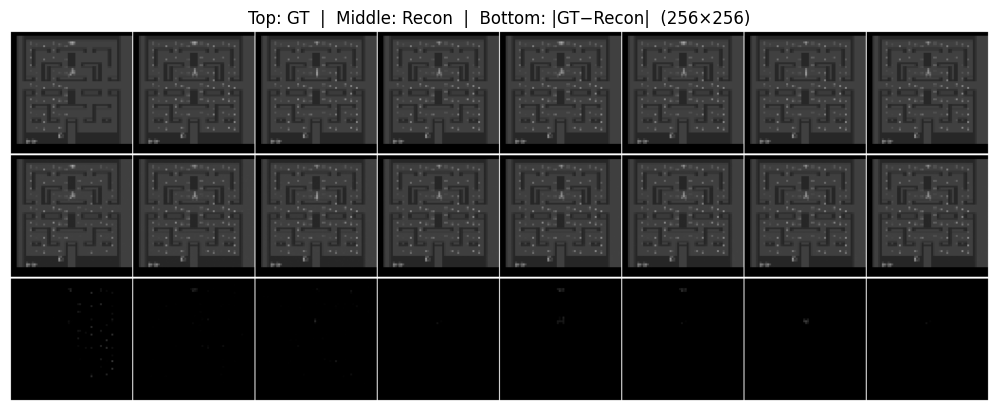

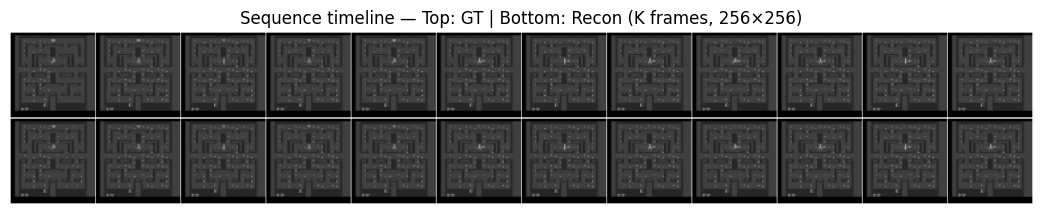

Saved: vjepa2_decoder_eval/gt_rec_diff_grid_256.png and timeline PNG.


In [ ]:
# === EVAL / VISUALIZATION (256×256, clip-based) ===
import os
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
decoder = decoder.to(tokens.device).eval()

decoder.eval()

@torch.no_grad()
def to_gray(x):  # (N,C,H,W)->(N,1,H,W) in [0,1]
    if x.size(1) == 1:
        return x
    return (0.299*x[:,0:1] + 0.587*x[:,1:2] + 0.114*x[:,2:3]).contiguous()

@torch.no_grad()
def psnr(pred, target, eps=1e-8):
    # pred/target: (N,1,H,W) in [0,1]
    mse = torch.mean((pred - target) ** 2, dim=(1,2,3)) + eps
    return 10.0 * torch.log10(1.0 / mse)

@torch.no_grad()
def ssim_simple(x, y, C1=0.01**2, C2=0.03**2):
    # Fast SSIM approx (global mean/var; good enough for quick checks)
    # x,y: (N,1,H,W) in [0,1]
    mu_x = torch.mean(x, dim=(2,3), keepdim=True)
    mu_y = torch.mean(y, dim=(2,3), keepdim=True)
    x_mu = x - mu_x
    y_mu = y - mu_y
    sigma_x2 = torch.mean(x_mu * x_mu, dim=(2,3), keepdim=True)
    sigma_y2 = torch.mean(y_mu * y_mu, dim=(2,3), keepdim=True)
    sigma_xy = torch.mean(x_mu * y_mu, dim=(2,3), keepdim=True)
    num = (2*mu_x*mu_y + C1) * (2*sigma_xy + C2)
    den = (mu_x**2 + mu_y**2 + C1) * (sigma_x2 + sigma_y2 + C2)
    ssim_map = num / (den + 1e-12)
    return ssim_map.view(ssim_map.shape[0])

# --- Grab ONE minibatch of sequences ---
imgs_b, acts_b, rews_b = next(iter(pt_loader))  # (B,T,256,256,3) float32 in [0,1]
imgs_b = imgs_b[:, :K_FRAMES].permute(0,1,4,2,3).contiguous().to(device)  # (B,K,3,256,256)
B, K = imgs_b.shape[:2]

# Targets at 256×256
frames_256 = imgs_b.reshape(-1, 3, 256, 256)              # (B*K,3,256,256)
targets_256 = frames_256 if not USE_GRAYSCALE else to_gray(frames_256)  # (B*K, C_tgt, 256,256)
targets_gray_256 = to_gray(frames_256)                     # always keep a gray copy for metrics

# --- Tokens via clips (centered) ---
with torch.no_grad():
    toks_bk = clips_to_center_tokens(imgs_b, override_T_in=T_IN)            # (B,K,D,Ht,Wt)
    tokens  = toks_bk.reshape(-1, toks_bk.size(2), toks_bk.size(3), toks_bk.size(4))  # (B*K,D,Ht,Wt)

# --- Recon @ native decoder size (should be 256×256) ---
with torch.no_grad():
    recons_256 = decoder(tokens).clamp(0, 1)                                 # (B*K,C_out,256,256)

# --- Metrics in grayscale (comparable across RGB/mono decoders) ---
recons_gray_256 = to_gray(recons_256)
psnr_vals = psnr(recons_gray_256, targets_gray_256)
ssim_vals = ssim_simple(recons_gray_256, targets_gray_256)
print(f"[Eval] Output size: {recons_256.shape[-2]}x{recons_256.shape[-1]} "
      f"| PSNR: {psnr_vals.mean().item():.2f} dB  |  SSIM: {ssim_vals.mean().item():.3f}")

# --- Visuals @ 256×256 ---
Nshow = min(8, recons_256.shape[0])

# Row 1: GT, Row 2: Recon, Row 3: |Diff| (diff shown in grayscale)
if USE_GRAYSCALE:
    gt_panel   = targets_256[:Nshow]               # (N,1,256,256)
    rec_panel  = recons_256[:Nshow]                # (N,1,256,256)
    diff_panel = (gt_panel - rec_panel).abs()
else:
    gt_panel   = frames_256[:Nshow]                # (N,3,256,256) for visualization
    rec_panel  = recons_256[:Nshow]                # (N,3,256,256)
    # Diff in grayscale to make errors pop
    diff_panel = (targets_gray_256[:Nshow] - recons_gray_256[:Nshow]).abs()  # (N,1,256,256)

gt_grid   = vutils.make_grid(gt_panel,   nrow=Nshow, pad_value=1.0)
rec_grid  = vutils.make_grid(rec_panel,  nrow=Nshow, pad_value=1.0)
diff_grid = vutils.make_grid(diff_panel, nrow=Nshow, pad_value=1.0)
stacked   = torch.cat([gt_grid, rec_grid, diff_grid], dim=1)  # (C, 256*3, 256*Nshow or 256*Nshow, H stacked)

plt.figure(figsize=(Nshow*1.6, 4.8))
img_np = stacked.permute(1,2,0).cpu().numpy()
if img_np.shape[2] == 1:
    plt.imshow(img_np.squeeze(-1), vmin=0, vmax=1, cmap="gray")
else:
    plt.imshow(img_np, vmin=0, vmax=1)
plt.axis('off')
plt.title("Top: GT  |  Middle: Recon  |  Bottom: |GT−Recon|  (256×256)")
plt.show()

# --- Timeline panel for one random sequence: show all K frames (GT top, Recon bottom) at 256 ---
b = random.randrange(B)
gt_seq_vis  = (targets_256 if USE_GRAYSCALE else frames_256).view(B, K, -1, 256, 256)[b]   # (K,C,256,256)
rec_seq_vis = recons_256.view(B, K, -1, 256, 256)[b]                                       # (K,C,256,256)

gt_seq_grid  = vutils.make_grid(gt_seq_vis,  nrow=K, pad_value=1.0)
rec_seq_grid = vutils.make_grid(rec_seq_vis, nrow=K, pad_value=1.0)
timeline = torch.cat([gt_seq_grid, rec_seq_grid], dim=1)

plt.figure(figsize=(K*1.1, 3.2))
tl_np = timeline.permute(1,2,0).cpu().numpy()
if tl_np.shape[2] == 1:
    plt.imshow(tl_np.squeeze(-1), vmin=0, vmax=1, cmap="gray")
else:
    plt.imshow(tl_np, vmin=0, vmax=1)
plt.axis('off')
plt.title("Sequence timeline — Top: GT | Bottom: Recon (K frames, 256×256)")
plt.show()

# --- Save PNGs ---
os.makedirs("vjepa2_decoder_eval", exist_ok=True)
plt.imsave("vjepa2_decoder_eval/gt_rec_diff_grid_256.png",
           (img_np.squeeze(-1) if img_np.shape[2]==1 else img_np), vmin=0, vmax=1, cmap=("gray" if img_np.shape[2]==1 else None))
plt.imsave(f"vjepa2_decoder_eval/timeline_b{b:03d}_256.png",
           (tl_np.squeeze(-1) if tl_np.shape[2]==1 else tl_np), vmin=0, vmax=1, cmap=("gray" if tl_np.shape[2]==1 else None))
print("Saved: vjepa2_decoder_eval/gt_rec_diff_grid_256.png and timeline PNG.")


# Saving Model

In [ ]:
from pathlib import Path
CKPT_DIR = Path("checkpointsfinal") / run_tag  # e.g., "vjepa2-decoder"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# device-agnostic: state_dict tensors carry their own device info
torch.save(decoder.state_dict(), CKPT_DIR / "decoder_weights_final.pt")

# OPTIONAL: safetensors (no pickle, faster/safer)
# pip install safetensors
# from safetensors.torch import save_file
# save_file(decoder.state_dict(), str(CKPT_DIR / "decoder_weights.safetensors"))



In [ ]:
import copy

cpu_copy = copy.deepcopy(decoder).to("cpu").eval()
try:
    scripted = torch.jit.script(cpu_copy)
    scripted.save(str(CKPT_DIR / "decoder_scripted.pt"))
except Exception:
    # If scripting fails, trace with a correctly-shaped dummy input
    D, Ht, Wt = int(tokens.shape[1]), int(tokens.shape[2]), int(tokens.shape[3])
    example = torch.randn(1, D, Ht, Wt)
    traced = torch.jit.trace(cpu_copy, example)
    traced.save(str(CKPT_DIR / "decoder_traced.pt"))


In [ ]:
from google.colab import files
files.download(str(CKPT_DIR / "best_weights.pt"))  # or any file you want


FileNotFoundError: Cannot find file: checkpointsfinal/20251012-123547/best_weights.pt

In [ ]:
test = build_decoder(**decoder_hparams)
test.load_state_dict(torch.load(CKPT_DIR / "decoder_weights.pt", map_location="cpu"))
test.to(device).eval()
with torch.no_grad():
    _ = test(tokens[:1].to(device))  # should run without errors


In [ ]:
# === Visualize ONE Pong sequence using the SAME pipeline as training ===
# Requires: parse_sequence_64to256, AtariSequenceDataset, clips_to_center_tokens, decoder
import os, numpy as np, torch, matplotlib.pyplot as plt, torchvision.utils as vutils
import tensorflow as tf
from torch.utils.data import DataLoader

# -------- Config / defaults (use your globals if present) --------
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_BF16      = bool(globals().get("USE_BF16", False))
USE_GRAYSCALE = bool(globals().get("USE_GRAYSCALE", True))   # set True if decoder is 1ch
amp_dtype     = torch.bfloat16 if USE_BF16 else torch.float16

SEQ_LEN       = int(globals().get("SEQ_LEN", 50))
BATCH_TF      = int(globals().get("BATCH_TF", 8))
BATCH_TORCH   = int(globals().get("BATCH_TORCH", 16))
NUM_WORKERS   = int(globals().get("NUM_WORKERS", 4))
DROP_LAST     = bool(globals().get("DROP_LAST", True))

K_FRAMES      = int(globals().get("K_FRAMES", 16))  # how many frames to slice from the episode
T_IN          = int(globals().get("T_IN", 4))       # temporal window used by clips_to_center_tokens

assert "decoder" in globals(), "decoder not defined"
assert "parse_sequence_64to256" in globals(), "parse_sequence_64to256(...) not defined"
assert "AtariSequenceDataset" in globals(), "AtariSequenceDataset not defined"
assert "clips_to_center_tokens" in globals(), "clips_to_center_tokens(...) not defined"

# -------- Helper(s) --------
@torch.no_grad()
def to_gray_batch(x):  # (N,C,H,W)->(N,1,H,W)
    if x.size(1) == 1:
        return x
    return (0.299*x[:,0:1] + 0.587*x[:,1:2] + 0.114*x[:,2:3]).contiguous()

# -------- Build TF dataset filtered to Pong (same ops as training) --------
base = "gs://rl_unplugged/atari_episodes_ordered/Pong/run_*"
files = tf.io.gfile.glob(base)
assert len(files) > 0, f"No TFRecords found at {base}"

episodes_dataset = tf.data.TFRecordDataset(files, compression_type="GZIP",
                                           num_parallel_reads=tf.data.AUTOTUNE)

dataset_pong = (episodes_dataset
                .map(parse_sequence_64to256, num_parallel_calls=tf.data.AUTOTUNE)
                .filter(lambda im, a, r: tf.shape(im)[0] >= SEQ_LEN)
                .map(lambda im, a, r: (im[:SEQ_LEN], a[:SEQ_LEN], r[:SEQ_LEN]))
                .batch(BATCH_TF, drop_remainder=True)
                .prefetch(tf.data.AUTOTUNE))

# Reuse the exact PyTorch wrapper you trained with
pong_seq_ds = AtariSequenceDataset(dataset_pong, num_tf_batches=1)  # just grab one TF batch
pt_loader_pong = DataLoader(
    pong_seq_ds,
    batch_size=BATCH_TORCH, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=False,
    persistent_workers=(NUM_WORKERS > 0),
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
)

# -------- Pull ONE batch and prep tokens (center-only & valid-window) --------
imgs_b, acts_b, rews_b = next(iter(pt_loader_pong))  # imgs_b: (B,T,256,256,3) float32 [0,1]
imgs_b = imgs_b[:, :K_FRAMES].permute(0,1,4,2,3).contiguous().to(device, non_blocking=True)  # (B,K,3,256,256)
B, K = imgs_b.shape[:2]

with torch.no_grad():
    toks_bk = clips_to_center_tokens(imgs_b, override_T_in=T_IN)  # (B,K,D,Ht,Wt)

# Center-only (best quality)
center = K // 2
tok_center = toks_bk[:, center].to(device, non_blocking=True)     # (B,D,Ht,Wt)

decoder = decoder.to(device).eval()
with torch.cuda.amp.autocast(dtype=amp_dtype), torch.no_grad():
    rec_center = decoder(tok_center).clamp(0, 1)                  # (B,C,256,256)

# Optional timeline over "valid" frames (full T_IN context only)
L = T_IN // 2
has_valid = (K - 2*L) > 0
if has_valid:
    tokens_valid = toks_bk[:, L:K-L].reshape(-1, toks_bk.size(2), toks_bk.size(3), toks_bk.size(4))
    tokens_valid = tokens_valid.to(device, non_blocking=True)      # (K_valid,D,Ht,Wt)
    with torch.cuda.amp.autocast(dtype=amp_dtype), torch.no_grad():
        recons_valid = decoder(tokens_valid).clamp(0, 1)           # (K_valid,C,256,256)

# -------- Prepare GT & panels --------
frames_256 = imgs_b.reshape(-1, 3, 256, 256)                       # (B*K,3,256,256)
gt_center  = frames_256.view(B, K, 3, 256, 256)[:, center]         # (B,3,256,256)

if USE_GRAYSCALE:
    gt_disp_center  = to_gray_batch(gt_center)
    rec_disp_center = rec_center if rec_center.size(1) == 1 else to_gray_batch(rec_center)
else:
    gt_disp_center  = gt_center
    rec_disp_center = rec_center if rec_center.size(1) == 3 else rec_center.repeat(1,3,1,1)

# Diff (grayscale for visibility)
gt_gray_center  = to_gray_batch(gt_center)
rec_gray_center = to_gray_batch(rec_center)
diff_center     = (gt_gray_center - rec_gray_center).abs()

# -------- Panel 1: Center frame (first item in batch) --------
idx = 0
gt_grid   = vutils.make_grid(gt_disp_center[idx:idx+1],   nrow=1, pad_value=1.0)
rec_grid  = vutils.make_grid(rec_disp_center[idx:idx+1],  nrow=1, pad_value=1.0)
diff_grid = vutils.make_grid(diff_center[idx:idx+1],      nrow=1, pad_value=1.0)
stacked   = torch.cat([gt_grid, rec_grid, diff_grid], dim=1)  # (C, 256*3, 256)

plt.figure(figsize=(4.8, 4.8))
img_np = stacked.permute(1,2,0).detach().cpu().numpy()
if img_np.shape[2] == 1:
    plt.imshow(img_np.squeeze(-1), vmin=0, vmax=1, cmap="gray")
else:
    plt.imshow(img_np, vmin=0, vmax=1)
plt.axis('off')
plt.title("Pong — Center frame: GT | Recon | |GT−Recon|")
plt.show()

# -------- Panel 2: Timeline over valid frames (first sequence), if any --------
if has_valid:
    gt_seq = frames_256.view(B, K, 3, 256, 256)[idx, L:K-L]       # (K_valid,3,256,256)
    if USE_GRAYSCALE:
        gt_seq_disp  = to_gray_batch(gt_seq)
        rec_seq_disp = recons_valid if recons_valid.size(1) == 1 else to_gray_batch(recons_valid)
    else:
        gt_seq_disp  = gt_seq
        rec_seq_disp = recons_valid if recons_valid.size(1) == 3 else recons_valid.repeat(1,3,1,1)

    nrow = gt_seq_disp.shape[0]
    gt_seq_grid  = vutils.make_grid(gt_seq_disp,  nrow=nrow, pad_value=1.0)
    rec_seq_grid = vutils.make_grid(rec_seq_disp, nrow=nrow, pad_value=1.0)
    timeline     = torch.cat([gt_seq_grid, rec_seq_grid], dim=1)

    plt.figure(figsize=(max(6, nrow*1.1), 3.2))
    tl_np = timeline.permute(1,2,0).detach().cpu().numpy()
    if tl_np.shape[2] == 1:
        plt.imshow(tl_np.squeeze(-1), vmin=0, vmax=1, cmap="gray")
    else:
        plt.imshow(tl_np, vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f"Pong — Sequence timeline (Top: GT | Bottom: Recon)  [K={K}, T_IN={T_IN}]")
    plt.show()
else:
    print(f"[Note] No valid frames for timeline (need K > {2*L}).")

# -------- Save (optional) & sanity prints --------
os.makedirs("vjepa2_decoder_eval", exist_ok=True)
plt.imsave("vjepa2_decoder_eval/pong_center_grid.png",
           (img_np.squeeze(-1) if img_np.shape[2]==1 else img_np),
           vmin=0, vmax=1, cmap=("gray" if img_np.shape[2]==1 else None))
if has_valid:
    plt.imsave("vjepa2_decoder_eval/pong_timeline.png",
               (tl_np.squeeze(-1) if tl_np.shape[2]==1 else tl_np),
               vmin=0, vmax=1, cmap=("gray" if tl_np.shape[2]==1 else None))

print({
    "device": str(device),
    "decoder_device": str(next(decoder.parameters()).device),
    "episode_len": int(frames_256.view(B, K, 3, 256, 256).shape[1]),
    "K_used": int(K),
    "T_IN": int(T_IN),
    "center_idx": int(center),
    "has_valid_timeline": bool(has_valid),
})
